   can_afford  knows_prod  likes_prod  subscription
0           1           0           0             0
1           1           1           0             0
2           1           0           1             0
3           1           0           1             1
4           1           1           1             0
   can_afford  knows_prod  likes_prod  subscription
0           0           0           0             1
1           0           1           0             1
2           1           0           1             1
3           0           0           1             1
4           1           1           0             1
Note: LogisticRegression's liblinear solver does not support sample_weight, replaced with 'lbfgs' sovler instead! No further action needed.
fit: lambda_=0 , mu_=0
--------- Results for LR fit -------
Accuracy:  0.4997
Weighted Accuracy:  0.817451426948
Expected reward LR (normalized):  (0.5597052588263971, 0.005911444258516258)
Expected reward LR (un-normalized):  (1.119409

/Users/dgoldma1/Documents/foraws/uplift/uplift.py:645: RuntimeWarning: invalid value encountered in double_scalars
  v_score_err = np.sqrt(v_top_err**2/v_bottom**2 + v_bottom_err**2 * v_top**2/v_bottom**4)


fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0


/Users/dgoldma1/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


fit: lambda_=0 , mu_=0
--------- Results for RF fit -------
Accuracy:  0.4997
Weighted Accuracy:  0.817451426948
Expected reward LR (normalized):  (0.5597052588263971, 0.005911444258516258)
Expected reward LR (un-normalized):  (1.1194094205566816, 0.009467164610363319)
H=1 ratio : 24902/50000
             precision    recall  f1-score   support

          0       0.50      0.50      0.50     24955
          1       0.50      0.50      0.50     25045

avg / total       0.50      0.50      0.50     50000

RF biases: {0: 0.50034000000000001, 1: 0.49965999999999999}
[ -1.00000000e-03   0.00000000e+00   1.00000000e-01   1.01946521e-01
   2.00000000e-01   5.11564050e-01   5.21455854e-01   8.07543121e-01
   1.00000000e+00   1.00010000e+00]
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0


/Users/dgoldma1/Documents/foraws/uplift/uplift.py:645: RuntimeWarning: invalid value encountered in double_scalars
  v_score_err = np.sqrt(v_top_err**2/v_bottom**2 + v_bottom_err**2 * v_top**2/v_bottom**4)


fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0
fit: lambda_=0 , mu_=0


/Users/dgoldma1/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


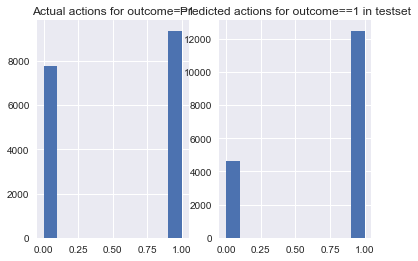

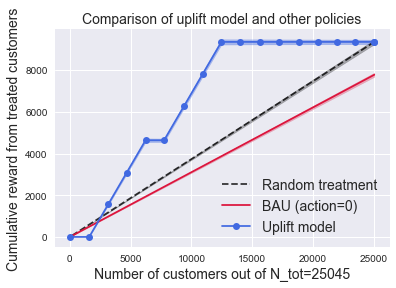

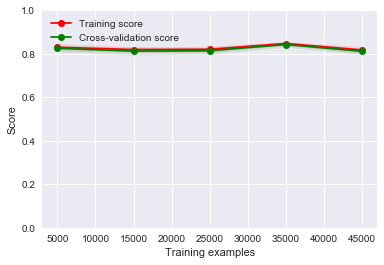

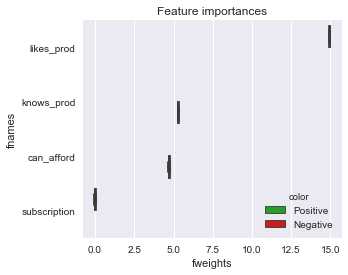

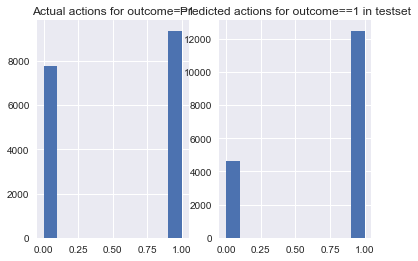

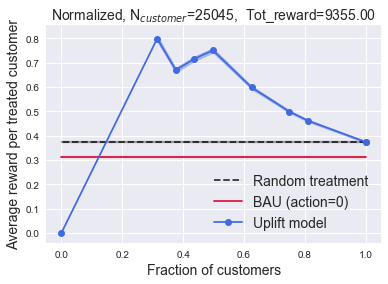

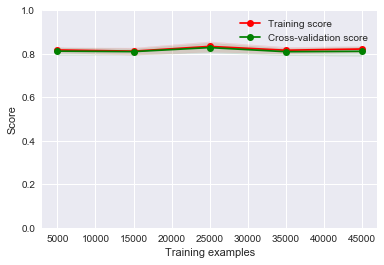

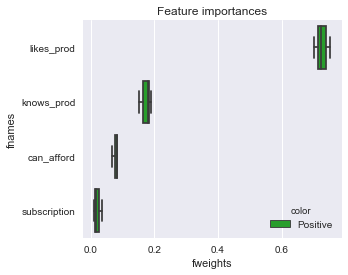

In [5]:
#from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import classification_report
from uplift import UpliftModel


'''Because input data is weighted by their responses (aks outcomes, rewards), those who don't
   responde (i.e., y=0) will be ignored for lambda_=0. Therefore, in the case where
   response only happens for a small fraction of data and feature space, the model
   will easily overfit and won't generalize since it only takes into account a small fraction of data.
   For instance, if response highly correlates with action (i.e., action ==1 -> response = 1),
   then all scenarios where action == 0 won't be seen by the model and thus the model
   won't be able to predict action=0 cases at all.

   To address this problem, we have to explore hyperparameter lambda_ and test it
   on validation set using un-weighted score.

   In addition, we also need to construct fake testing data carefully to avoid
   the above mentioned issue.
'''

def make_fake_data(n=50000, plot=True):
    '''To address the above issue, we construct a fake data set as follows:
   1. Features:
       - Feature1 : can_afford product
       - Feature2 : knows_product
       - Feature3 : likes_product
       - Feature4 : current subscriber

   2. Outcome (aka reward, response) = 1, if:
       - can_afford==1 & knows_prod ==1 & likes_prod ==1, regardless of sub and action
       - can_afford==1 & knows_prod ==0 & likes_prod ==1 & sub==0 or 1 & action ==1
       - can_afford==1 & knows_prod ==1 & likes_prod ==0 & sub==1 & action ==0
       - can_afford==1 & knows_prod ==0 & likes_prod ==0 & sub==1 & action ==0
       - can_afford==0 & knows_prod ==0 & likes_prod ==1 & sub==1 & action ==1
       - can_afford==0 & knows_prod ==1 & likes_prod ==1 & sub==1 & action ==1
       - can_afford==0 & knows_prod ==0 & likes_prod ==0 & sub==1 & action ==0
      else outcome = 0

    This way we can make sure that each feature can result in positive response with both action=1 or 0
    for different scenarios. There is also a limit of how well the model can do due to two cases
    where action does not affect response.
'''
    can_afford = np.random.randint(2, size=n)
    knows_prod = np.random.randint(2, size=n)
    likes_prod = np.random.randint(2, size=n)
    sub = np.random.randint(2, size=n)
    action = np.random.randint(2, size=n)

    outcome = np.zeros(n)
    outcome[np.where((can_afford==1) & (knows_prod ==1) & (likes_prod ==1))[0]] = 1
    outcome[np.where((can_afford==1) & (knows_prod ==0) & (likes_prod ==1) & (action ==1))[0]] = 1
    outcome[np.where((can_afford==1) & (knows_prod ==1) & (likes_prod ==0) & (sub==1) & (action ==0))[0]]=1
    outcome[np.where((can_afford==1) & (knows_prod ==0) & (likes_prod ==0) & (sub==1) & (action ==0))[0]]=1
    outcome[np.where((can_afford==0) & (knows_prod ==0) & (likes_prod ==1) & (sub==1) & (action ==1))[0]]=1
    outcome[np.where((can_afford==0) & (knows_prod ==1) & (likes_prod ==1) & (sub==1) & (action ==1))[0]]=1
    outcome[np.where((can_afford==0) & (knows_prod ==0) & (likes_prod ==0) & (sub==1) & (action ==0))[0]]=1

    if plot:
        figure, ax=plt.subplots(1,3)
        ax[0].hist(outcome)
        ax[0].set_title('Histogram for Outcome')
        ax[1].hist(action)
        ax[1].set_title('Actions')
        ax[2].hist(action[np.where(outcome==1)[0]])
        ax[2].set_title('Actions for outcome==1')

    Xs = pd.DataFrame({'can_afford':can_afford, 'knows_prod':knows_prod,
                             'likes_prod':likes_prod, 'subscription':sub})
    return Xs, action, outcome


def main():
    # fake data
    n=50000
    Xs_train, actions_train, outcomes_train = make_fake_data(n=n, plot=False)
    print(Xs_train.head())

    Xs_test, actions_test, outcomes_test = make_fake_data(n=n, plot=False)
    print(Xs_test.head())


    # Logistic Regression Model
    LRUplift = UpliftModel(LR) # Initialize UpliftModel class
    LRUplift.fit(Xs_train, actions_train, outcomes_train, lambda_= 0, plot_weight_hist=False)
    LRpredictions = LRUplift.predict(Xs_test)

    # Compare actual and predicted action histograms
    fig, ax=plt.subplots(1,2)
    ax[0].hist(actions_test[np.where(outcomes_test==1)[0]])
    ax[0].set_title('Actual actions for outcome==1')
    ax[1].hist(LRpredictions[np.where(outcomes_test==1)[0]])
    ax[1].set_title('Predicted actions for outcome==1 in testset')
    plt.draw()

    print('--------- Results for LR fit -------')
    print('Accuracy: ', LRUplift.score(Xs_test, actions_test, outcomes_test, weighted=False))
    print('Weighted Accuracy: ', LRUplift.score(Xs_test, actions_test, outcomes_test, weighted=True))
    print('Expected reward LR (normalized): ', LRUplift.v_score(Xs_test, actions_test, outcomes_test, normalize=True))
    print('Expected reward LR (un-normalized): ', LRUplift.v_score(Xs_test, actions_test, outcomes_test, normalize=False))
    print('H=1 ratio : {0}/{1}'.format(np.sum(LRpredictions), len(LRpredictions)))
    print(classification_report(actions_test, LRpredictions))
    print('LR biases:', LRUplift.bias_dict)

    # bob plot and results. LR_bob is a pandas DataFrame allows custom plots
    LR_bob=LRUplift.bob_curve(Xs_test, actions_test, outcomes_test, normalize_population=False)
    #print(LR_bob.head)

    # plot learning curve, showing bias and variance versus number of training data points
    LRUplift.plot_learning_curve(Xs_test, actions_test, outcomes_test)

    # plot feature importances
    LRUplift.plot_importances(Xs_test, actions_test, outcomes_test)

    # RandomForeset model
    RFUplift = UpliftModel(RF)
    RFUplift.fit(Xs_train, actions_train, outcomes_train, lambda_= 0, plot_weight_hist=False)
    RFpredictions = RFUplift.predict(Xs_test)

    # Compare actual and predicted action histograms
    fig, ax=plt.subplots(1,2)
    ax[0].hist(actions_test[np.where(outcomes_test==1)[0]])
    ax[0].set_title('Actual actions for outcome==1')
    ax[1].hist(RFpredictions[np.where(outcomes_test==1)[0]])
    ax[1].set_title('Predicted actions for outcome==1 in testset')
    plt.draw()

    print('--------- Results for RF fit -------')
    print('Accuracy: ', RFUplift.score(Xs_test, actions_test, outcomes_test, weighted=False))
    print('Weighted Accuracy: ', RFUplift.score(Xs_test, actions_test, outcomes_test, weighted=True))
    print('Expected reward LR (normalized): ', RFUplift.v_score(Xs_test, actions_test, outcomes_test, normalize=True))
    print('Expected reward LR (un-normalized): ', RFUplift.v_score(Xs_test, actions_test, outcomes_test, normalize=False))
    print('H=1 ratio : {0}/{1}'.format(np.sum(RFpredictions), len(RFpredictions)))
    print(classification_report(actions_test, RFpredictions))
    print('RF biases:', RFUplift.bias_dict)

    # bob plot and results. RF_bob is a pandas DataFrame allows custom plots
    RF_bob=RFUplift.bob_curve(Xs_test, actions_test, outcomes_test, normalize_population=True)
    #print(RF_bob.head)

    # plot learning curve, showing bias and variance versus number of training data points
    RFUplift.plot_learning_curve(Xs_test, actions_test, outcomes_test)

    # plot feature importances
    RFUplift.plot_importances(Xs_test, actions_test, outcomes_test)

    plt.show()

if __name__ == '__main__':
    main()